## Fonctions et Méthodes de calculs : Partie premier

Cette partie regroupe plusieurs méthodes de calculs sous forme de fonctions Python. Ceci pour définir des algorithmes utilisables pour les aires d'alimentation.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import ifm as ifm
import pandas as pds
from scipy.stats import gmean

class zuper:

    doc = ''
    
    #####################
    # Instance variable #
    #####################
    
    def __init__(self, url_file):
        
        #get feflow file
        self.doc = ifm.loadDocument(url_file)

        print("Object created !")

data = zuper(r'C:\zuper\final_case.fem')

doc = data.doc
nnodes = doc.getNumberOfNodes()
nelements = doc.getNumberOfElements()
x, y = np.zeros((nnodes,)), np.zeros((nnodes,))
for i in range(nnodes):
    x[i] = doc.getX(i)
    y[i] = doc.getY(i)

xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
dx = x[1] - x[0]
nbx_el = int(np.round( (xmax - xmin)/dx ))
dy = y[0] - y[nbx_el + 1]
nby_el = int(np.round( (ymax - ymin)/dy ))
s = dx*dy
nbx_nd, nby_nd = nbx_el + 1, nby_el + 1
ox, oy = doc.getOriginX(), doc.getOriginY()
qw = float( str( doc.createWellManager().getWells()[0].getPropertyValue(8) ).split('[')[0] )
xw = int(float(str( doc.createWellManager().getWells()[0].getPropertyValue(3)).split(' ')[0]))
yw = int(float(str( doc.createWellManager().getWells()[0].getPropertyValue(4)).split(' ')[0]))
for i in range(nnodes):
    if int( x[i] ) == xw and int( y[i] ) == yw:
        id_well = i

x.shape = (nby_nd, nbx_nd)
y.shape = (nby_nd, nbx_nd)

for i in range(nby_nd):
    for j in range(nbx_nd):
        if int(x[i][j])==xw and int(y[i][j])==yw:
            id_well_mesh = [i,j]

cov_mod = gn.covModel.CovModel2D([('spherical', {'w':0.25, 'r':[1300, 1300]})], 0, 'title')

Object created !


### Fonction de simulation aléatoire

Cette fonction comprend la méthode de simulation aléatoire obtenable grâce au module Geone. Elle est caractérisé par 7 arguments à définir lorsque la fonction est utilisée :

<ul>
    <li>nx : nombre de noeuds selon l'axe x (soit la variable nbx_nd ou nbx_el)</li>
    <li>ny : nombre de noeuds selon l'axe y (soit la variable nby_nd ou nby_el)</li>
    <li>x : tableau de données des positions des données conditionnantes</li>
    <li>v : liste de données des valeurs des données conditionnantes</li>
    <li>mu et std : moyenne et écart-type respective à la simulation du paramètre</li>
    <li>seed : numéro de la graine pour faire une simulation de référence</li>
</ul>

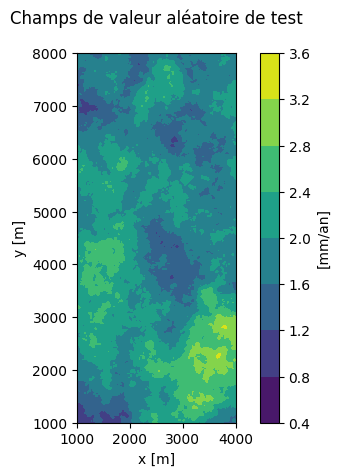

In [26]:
def simulation_sgs(nx, ny, x, v, mu, std, seed=None):
    if x is None:
        return gn.geosclassicinterface.simulate2D(cov_mod, (nx, ny), (dx, dy), (ox, oy), x = np.array([[61, 244]])*np.array([dx, dy]), v = [2.5], mean=mu, var=std**2, seed=seed, verbose=0)['image'].val[0][0]
        
    return gn.geosclassicinterface.simulate2D(cov_mod, (nx, ny), (dx, dy), (ox, oy), x = x*np.array([dx,dy]), v = v, mean=mu, var=std**2, seed=seed, verbose=0)['image'].val[0][0]

test = simulation_sgs(nbx_nd, nby_nd, None, None, 1.8, 0.35, seed=None)

plt.figure()
plt.contourf(x, y, test)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Champs de valeur aléatoire de test\n")
plt.colorbar().set_label('[mm/an]')
plt.axis([xmin, xmax, ymin, ymax])
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks((1000, 2000, 3000, 4000))
plt.show()

### Obtenir les valeurs de références pour les calculs

Cette fonction comprend la méthode pour définir et sauvegarder les valeurs de références des paramètres utilisées pour la suite des calculs. Elle n'utilise aucun argument de fonction. Il n'y a par forcément de message ou d'information données, car elle initie les données des différentes variables dans la classe Python de base.

In [109]:
def get_params():    
    k_matrix = simulation_sgs(nbx_nd, nby_nd, np.array([[61, 244]]), [2.5], 1.8, 0.35, seed=8948474)
    k_matrix_el = k_matrix[:nby_el, :nbx_el]
    k_mean = gmean(k_matrix, axis=None)
    
    r_matrix = simulation_sgs(nbx_nd, nby_nd, np.array([[61, 244]]), [401.5], 400, 15, seed=7528660)
    r_matrix_el = r_matrix[:nby_el, :nbx_el]
    r_mean = np.mean(r_matrix, axis=None)/365/1000

    b = doc.getParamValue(108, 0) - doc.getParamValue(106, 0)
    f = doc.getParamValue(201, 0)

    return k_matrix, k_matrix_el, k_mean, r_matrix, r_matrix_el, r_mean

k_matrix, k_matrix_el, k_mean, r_matrix, r_matrix_el, r_mean = get_params()
print("Initiatlisation finit ! ")

Initiatlisation finit ! 


### Initier les valeurs des paramètres dans Feflow et simulation numérique

Cette fonction permet la mise en place des valeurs numériques obtenue par Python dans le fichier Feflow utilisée pour définir un nouveau champ de valeur dans ce dernier. Elle comprend deux arguments de fonction que sont :

<ul>
    <li>list_id_parms : liste des ID de chaque paramètre du fichier Feflow à modifier</li>
    <li>list_val_parms : liste des valeurs de chaque paramètre du fichier Feflow à remplacer</li>
</ul>

In [73]:
def set_parameters_and_simulation(list_id_parms, list_val_parms):
    for j in range(len(list_id_parms)):
        for i in range(nelements):
            doc.setParamValue(list_id_parms[j], i, list_val_parms[j][i])

    doc.startSimulator()
    doc.stopSimulator()

set_parameters_and_simulation([100], [10**(k_matrix_el.flatten())])
print("Inintiation et simulation dans le fichier Feflow finit ! ")

Inintiation et simulation dans le fichier Feflow finit ! 


Une autre syntaxe existe pour définir cette fonction et est trouvable ci-dessous pour la compater au mieux :

In [74]:
def set_parameters_and_simulation_bis(list_id_parms, list_val_parms):
    [ doc.setParamValue( list_id_parms[j], i, list_val_parms[j][i] ) for i in range(nelements) for j in range(len(list_id_parms)) ]
    doc.startSimulator()
    doc.stopSimulator()

set_parameters_and_simulation_bis([100], [10**(k_matrix_el.flatten())])
print("Inintiation et simulation dans le fichier Feflow finit ! ")

Inintiation et simulation dans le fichier Feflow finit ! 


### Obtenir les valeurs des simulations numériques

Cette fonction est utilisée pour regrouper dans un dictionnaire toutes les données des résultats provenant de la simulation numérique avec Feflow. On y retrouve la charge hydraulique, l'âge moyen de l'eau souterraine, le temps de sortie et les probabilités de captures et le champ de contributions. Elle comprend 1 argument de fonction qui est déjà définie dans la fonction elle-même qui est :

<ul>
    <li>name_res : nom des variables pour obtenir les résultats de la simulations numérique avec Feflow</li>
</ul>

In [88]:
dict_params = {'recharge':r_matrix/365/1000}
dict_results = {}

def get_results(name_res=['charge', 'age', 'exit-time', 'probabilities']):
    var = 1
    for name in name_res:
        if name=='charge':
            dict_results[name] = np.array([ doc.getResultsFlowHeadValue(i) for i in range(nnodes) ])
            dict_results[name].shape = (nby_nd, nbx_nd)

        elif name in ['age', 'exit-time', 'probabilities']:
            doc.setMultiSpeciesId(var)
            dict_results[name] = np.array([ doc.getResultsTransportMassValue(i) for i in range(nnodes) ])
            dict_results[name][ dict_results[name]<0 ] = 0
            dict_results[name].shape = (nby_nd, nbx_nd)
            var+=1

    dict_results['contributions'] = dict_results['probabilities'] * dict_params['recharge'] * s

get_results()
for i in dict_results.keys():
    print(i, "=", dict_results[i], "\n")

charge = [[30.23231636 30.23225241 30.23205546 ... 30.26149247 30.2617123
  30.26177902]
 [30.2322341  30.23217653 30.23194445 ... 30.26145716 30.2616835
  30.26175942]
 [30.23188813 30.23176672 30.23149769 ... 30.26133367 30.26161847
  30.2617132 ]
 ...
 [10.78850028 10.80625886 10.83432884 ... 10.48126981 10.45928852
  10.44241887]
 [10.42028806 10.43109253 10.43385663 ... 10.24266917 10.25564637
  10.26576395]
 [10.         10.         10.         ... 10.         10.
  10.        ]] 

age = [[7991.58559353 7991.56924443 7991.51729075 ... 7999.31305755
  7999.3631913  7999.38805834]
 [7991.53346771 7991.53625302 7991.49574953 ... 7999.32220084
  7999.36671401 7999.38651493]
 [7991.42916088 7991.44630602 7991.40926852 ... 7999.31180147
  7999.35250715 7999.36983874]
 ...
 [5768.04689184 5778.38497337 5805.11361577 ... 6148.01074551
  6155.09259225 6158.32210131]
 [5749.29819754 5758.79325826 5784.34538688 ... 6133.26723453
  6140.96740951 6144.44827487]
 [5741.22242442 5750.29147017 5

### Obtenir les autres paramètres du modèle numérique 

Cette fonction permet de définir un DataFrame à partir des paramètres non-modifiées du fichier Feflow. Comme elle contient 1 argument de fonction, l'ensemble des paramètres voulue sera affichée selon la liste suivante :

<ul>
    <li>A</li>
    <li>Theta</li>
    <li>ztop</li>
    <li>zbot</li>
    <li>S</li>
    <li>alpha</li>
    <li>K</li>
    <li>lambda</li>
    <li>D</li>
    <li>d_l</li>
    <li>d_t</li>
</ul>

In [104]:
dtframe_constant = pds.DataFrame([])

def get_constants(list_of_id):
    '''
    -------------------------------------------------------
    
    Aim : Function which get the values of the constants
    parameters from the Feflow files
    
    -------------------------------------------------------
    
    Valeur input : 
        - list_of_id : list of number corresponding to
        the Id of the parameter in Feflow files [-]
        
    Valeur output :
        - nothing
        
    -------------------------------------------------------
    '''

    # title of the DataFrame
    tab = [r'$A$ [-]', r'$\theta$ [deg]', r'$z_{t}$ [m]', r'$z_{b}$ [m]', r'$S$ [-]', r'$\alpha$ [-]', r'$K$ [-]', r'$\lambda$ [1/d]', r'$D$ [m2/s]', r'$d_{l}$ [m]', r'$d_{t}$ [m]']
    
    # for loop to put constant values in the DataFrame
    for i in range(len(list_of_id)):
        dtframe_constant[tab[i]] = [doc.getParamValue(list_of_id[i], 0)]

get_constants([108, 112, 208, 206])
print(dtframe_constant)

   $A$ [-]  $\theta$ [deg]  $z_{t}$ [m]  $z_{b}$ [m]
0    100.0          0.0001          0.0          0.0


### Choisir les cas d'études

Cette fonction permet de définir le cas d'étude pour délimiter une aire d'alimentation, que ce soit pour une étude déterministe ou stochastique. Elle comprend trois arguments de fonction :

<ul>
    <li>conditional : valeur booléenne représentant l'utilisation de données conditionnantes</li>
    <li>perm_sim : valeur booléenne représentant l'utilisation d'un champ de conductivité hydraulique aléatoire ou non</li>
    <li>rech_sim : valeur booléenne représentant l'utilisation d'un champ de recharge aléatoire ou non</li>
</ul>

Par la suite, elle utilise la fonction "set_parameters_and_simulation" définie préalablement pour modifier les valeurs dans le fichier Feflow et faire la simulation numérique.

Elle permet donc de définir l'hétérogénéité des paramètres (conductivité hydraulique et recharge)

In [111]:
dict_params = {}
pos_cond = np.array([ [108, 16], [65, 67], [20, 54], [7, 135], [115, 151], [102, 232] ])
v1, v2 = [1.728, 1.292, 1.509, 2.014, 1.969, 1.618], [350.97, 416.00, 405.42, 437.91, 392.40, 363.45]
mu_k, std_k, mu_r, std_r = 1.8, 0.35, 400, 15

def set_variation_homogeneity(conditional=False, perm_sim=False, rech_sim=False):
    if conditional==True:
        dict_params['conductivity'] = simulation_sgs(nbx_nd, nby_nd, pos_cond, v1, mu_k, std_k, seed=None)
        dict_params['recharge'] = simulation_sgs(nbx_nd, nby_nd, pos_cond, v2, mu_r, std_r, seed=None)/365/1000
        
    else:
        if perm_sim==True:
            dict_params['conductivity'] = k_matrix
        else:
            dict_params['conductivity'] = np.ones((nby_nd, nbx_nd))*k_mean
            
        if rech_sim==True:
            dict_params['recharge'] = r_matrix/365/1000
        else:
            dict_params['recharge'] = np.ones((nby_nd, nbx_nd))*r_mean

    k_el = dict_params['conductivity'][:nby_el, :nbx_el]
    r_el = dict_params['recharge'][:nby_el, :nbx_el]

    set_parameters_and_simulation([100, 113], [10**k_el.flatten(),  r_el.flatten()])

print("K-R Homogène")
set_variation_homogeneity(conditional=False, perm_sim=False, rech_sim=False)
for i in dict_params.keys():
    print(i, "=", dict_params[i], "\n")

print("\nK Homogène - R Hétérogène")
set_variation_homogeneity(conditional=False, perm_sim=False, rech_sim=True)
for i in dict_params.keys():
    print(i, "=", dict_params[i], "\n")

print("\nK Hétérogène - R Hétérogène")
set_variation_homogeneity(conditional=False, perm_sim=True, rech_sim=True)
for i in dict_params.keys():
    print(i, "=", dict_params[i], "\n")

print("\nDonnées conditionnantes")
set_variation_homogeneity(conditional=True)
for i in dict_params.keys():
    print(i, "=", dict_params[i], "\n")

K-R Homogène
conductivity = [[1.83086163 1.83086163 1.83086163 ... 1.83086163 1.83086163 1.83086163]
 [1.83086163 1.83086163 1.83086163 ... 1.83086163 1.83086163 1.83086163]
 [1.83086163 1.83086163 1.83086163 ... 1.83086163 1.83086163 1.83086163]
 ...
 [1.83086163 1.83086163 1.83086163 ... 1.83086163 1.83086163 1.83086163]
 [1.83086163 1.83086163 1.83086163 ... 1.83086163 1.83086163 1.83086163]
 [1.83086163 1.83086163 1.83086163 ... 1.83086163 1.83086163 1.83086163]] 

recharge = [[0.00109916 0.00109916 0.00109916 ... 0.00109916 0.00109916 0.00109916]
 [0.00109916 0.00109916 0.00109916 ... 0.00109916 0.00109916 0.00109916]
 [0.00109916 0.00109916 0.00109916 ... 0.00109916 0.00109916 0.00109916]
 ...
 [0.00109916 0.00109916 0.00109916 ... 0.00109916 0.00109916 0.00109916]
 [0.00109916 0.00109916 0.00109916 ... 0.00109916 0.00109916 0.00109916]
 [0.00109916 0.00109916 0.00109916 ... 0.00109916 0.00109916 0.00109916]] 


K Homogène - R Hétérogène
conductivity = [[1.83086163 1.83086163 1.8

### Obtenir les positions et valeurs des données conditionnantes

Cette fonction permet de définir les positions et valeurs des données conditionnantes. Ces données sont définis de manière aléatoire avec la méthode np.random.choice du module Numpy. Un test est fait dans la fonction pour savoir s'il y a des doublons dans les positions des données conditionnantes, ceci à cause du fait que la simulation aléatoire, faite avec Geone, peut ne pas fonctionner lorsqu'il y a des répétitions des positions.

Elle comprend deux arguments de fonction que sont :

<ul>
    <li>N : le nombre de données conditionnantes</li>
    <li>value_param_well : liste des valeurs des paramètres spécifique à la position du puits</li>
</ul>

Après que le test soit fait, l'ajout des positions et la valeur du puits à la liste des données conditionnantes est définie.

x =  [[  6. 213.]
 [  8.  84.]
 [ 11.  48.]
 [ 13. 106.]
 [ 16.  72.]
 [ 17.  68.]
 [ 20.  65.]
 [ 27. 191.]
 [ 31. 203.]
 [ 32.  24.]
 [ 33. 159.]
 [ 35. 273.]
 [ 40.  83.]
 [ 41. 265.]
 [ 43. 118.]
 [ 47. 274.]
 [ 48. 208.]
 [ 52. 133.]
 [ 64. 277.]
 [ 73. 116.]
 [ 74. 238.]
 [ 76.  99.]
 [ 83. 130.]
 [ 83. 279.]
 [ 97. 275.]
 [ 98. 135.]
 [112. 174.]
 [115. 261.]
 [117. 113.]
 [118. 106.]
 [ 62. 241.]]

v1 =  [2.209383195725827, 1.7388577948274568, 2.0972992757757045, 2.1908720308561747, 1.4768759081073934, 1.4490745807505925, 1.7488543948582462, 2.358584633806069, 2.2733000109875166, 1.9538606308735051, 1.408618156444156, 1.23166516329466, 1.6881272283773052, 1.5425040155064054, 1.4324914830493471, 1.679439038397847, 2.3925482476097564, 1.2037505213269104, 2.0490558909639156, 1.6595026956327303, 1.8508358588329472, 1.9227266773858191, 1.0828714842347358, 1.4589994771491703, 1.7052855504891482, 1.2710856920172153, 2.1566778620849125, 1.4541040091631467, 1.578335439073333, 1.75926245

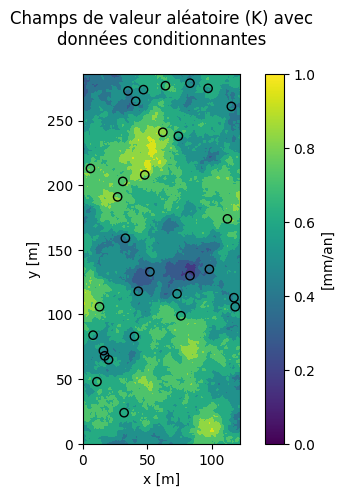

In [137]:
def get_pos_and_data_for_condi_test(N, value_param_well):
    mesh_x = np.random.choice(122, N)
    mesh_y = np.random.choice(286, N)
    v1, v2 = np.zeros((N,)), np.zeros((N,))
    pos_cond = np.zeros((N,2)) 
    
    for i in range(N):
        pos_cond[i] = mesh_x[i], mesh_y[i]
        v1[i] = k_matrix_el[ mesh_y[i] ][ mesh_x[i] ]
        v2[i] = r_matrix_el[ mesh_y[i] ][ mesh_x[i] ]

    test_bis = np.unique(pos_cond, axis=0, return_index=True)

    pos_cond = test_bis[0].copy()

    v1 = [v1[test_bis[1][i]] for i in range(len(pos_cond))]
    v2 = [v2[test_bis[1][i]] for i in range(len(pos_cond))]

    pos_cond = np.vstack((pos_cond, [62, 241]))
    v1.append(value_param_well[0])
    v2.append(value_param_well[1])

    return pos_cond, v1, v2

ps, v11, v22 = get_pos_and_data_for_condi_test(30, [1.5, 400])
print("x = ",ps)
print("\nv1 = ",v11)
print("\nv2 = ",v22,"\n")

plt.figure()
plt.contourf(k_matrix)
plt.scatter(ps[:,0], ps[:,1], facecolors='none', edgecolors='black')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Champs de valeur aléatoire (K) avec\ndonnées conditionnantes\n")
plt.colorbar().set_label('[mm/an]')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()